## Classification of generated trading signals

Various machine learning algorithms can be used to **generate trading signals** in an attempt to predict the market’s movement. The problem of predicting a buy or sell signal for a trading strategy is defined in the **classification** framework, where the predicted variable has a value of 1 for buy and 0 for sell. This signal is decided through the comparison of the short-term and long-term price trends. Different trend and momentum indicators are created from the data and are added as features to enhance the performance of the prediction model.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Download data from Yahoo Finance
dataset = yf.download('BTC-EUR', period='max', interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# describe data
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3466.000000,3466.000000,3466.000000,3466.000000,3466.000000,3.466000e+03
mean,13602.456106,13913.409582,13278.494705,13620.162784,13620.162784,1.499040e+10
std,14819.559098,15167.656893,14459.210460,14842.973214,14842.973214,1.675400e+10
min,150.128998,183.047470,145.483078,151.152512,151.152512,4.640334e+06
25%,919.609787,939.306778,893.059891,923.225632,923.225632,1.784987e+08
50%,7405.542480,7603.579346,7227.367676,7414.778076,7414.778076,1.103496e+10
75%,24089.773438,24448.961914,23846.444824,24102.009277,24102.009277,2.484461e+10
max,65408.882812,67409.164062,65301.093750,66374.468750,66374.468750,2.907271e+11


In [4]:
# Checking for any null values and removing the null values
print('Null Values =',dataset.isnull().values.any())

Null Values = False


### Data preparation
We create the target variable "signal" that will indicate whether the trading signal is buy or sell. We define the short-term price as the 10-days rolling average and the long-term price as the 60-day rolling average. We use the label 1 (BUY signal) if the short-term is higher than the long-term price, 0 (SELL signal) otherwise.
#### Target variable

In [5]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

#### Feature engineering
FE is the task of identifing and constructing new features given raw data. In this case we compute some *momentum* indicators.

**Moving average** indicate a price trend by cutting down the amount of noise in the series. Rising MA indicates that the asset is in an uptrend, while a declining MA indicates a downtrend. A simple moving average is calculated by taking the arithmetic mean of a given set of values over a specified period:

$SMA = \frac{A_1+A_2 +\ldots + A_n}{n}$

where  $n$ is the number of time periods.

In [6]:
def MA(df, n):
    # Rolling function: apply a function to a window of data
    # the window takes the n-1 point before the cosidered point
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

**Exponential moving average** puts more enphasis on the recent data points, is considered a weighted average calculation. The EMA responds more quickly to the changing prices that the SMA.

In [7]:
def EMA(df, n):
    # ewm: exponential moving window (pandas method)
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

**Stochastic oscillator** is a momentum indicator that compares the closing price of a security to a range of its previous prices over a certain period of time. There are 2 SO, **%K** and **%D**, the first is referred as the fast stochastic indicator and the latter as the slow one. Indeed %D is takes as the 3-periods moving average of %K. The general theory serving as the foundation for this indicator is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low.  The stochastic oscillator is computed as:

$\%K = \frac{C-L_n}{H_n-L_n} $

where
- $C$ is the most recent close price
- $L_n$ is the lowest price traded in the last n periods
- $H_n$ is the highest price traded during the last n periods

In [8]:
def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOD = STOK(close, low, high, n).rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

**Relative strength index** is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. It can range from 0 to 100. An asset is deemed to be overbought once the RSI approaches 70, meaning that the asset may be getting overvalued and is a good candidate for a pullback. Likewise, if the RSI approaches 30, it is an indication that the asset may be getting oversold and is therefore likely to become undervalued.

In [9]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

**Rate of change**  is a momentum oscillator that measures the percentage change between the current price and the $n$ period past prices and refers to how quickly something changes over time. Assets with higher ROC values are considered more likely to be overbought; those with lower ROC, more likely to be oversold. It can be computed as:

$ROC = \frac{C - C_n}{C_n}\times100$

where
- $C$ is the close price
- $C_n$ is the close price $n$ periods before

In [10]:
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

**Momentum** s the rate of acceleration of a security’s price or volume, that is the speed at which the price is changing. It is computed as the difference between the current time and price of the $n$ previos periods:

$MOM = P-P_n$

In [11]:
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

In [12]:
dataset.tail(5)

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,MA21,...,%D30,%K200,%D200,RSI10,RSI30,RSI200,ROC10,ROC30,MOM10,MOM30
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-09,61124.921875,63992.132812,60486.019531,62411.535156,62411.535156,54098645569,59324.157813,45231.270378,1.0,59324.157813,...,89.978431,96.125927,94.132702,74.043620,72.889406,62.285118,8.223284,48.483457,9755.589844,21283.378906
2024-03-10,62410.769531,62752.339844,62185.855469,62593.183594,62593.183594,19746552762,59816.553125,45571.048372,1.0,59816.553125,...,92.018098,96.571151,95.465782,74.364278,73.042286,62.342729,10.522585,43.177338,4923.953125,20560.531250
2024-03-11,62594.437500,63969.632812,62389.562500,63072.972656,63072.972656,32609410343,60460.466406,45914.126953,1.0,60460.466406,...,94.078647,97.747122,96.814733,75.261199,73.451356,62.494810,9.552306,42.390034,6439.132812,19355.730469
2024-03-12,63073.671875,66681.351562,61394.554688,65983.203125,65983.203125,60121474891,61301.448047,46310.169727,1.0,61301.448047,...,95.351294,98.394640,97.570971,79.981540,75.759468,63.395983,15.366099,47.533637,8409.816406,21687.285156
2024-03-13,65408.882812,67409.164062,65301.093750,66374.468750,66374.468750,56432590848,62219.432813,46764.988477,1.0,62219.432813,...,95.978655,97.659929,97.933897,80.536321,76.049072,63.514440,13.925262,43.115305,9179.847656,21650.292969


In [13]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
dataset = dataset.dropna(axis=0)

### Data visualization

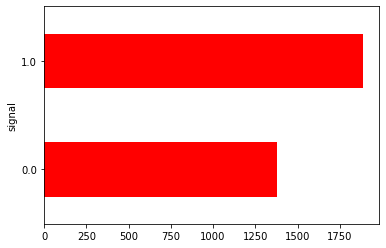

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

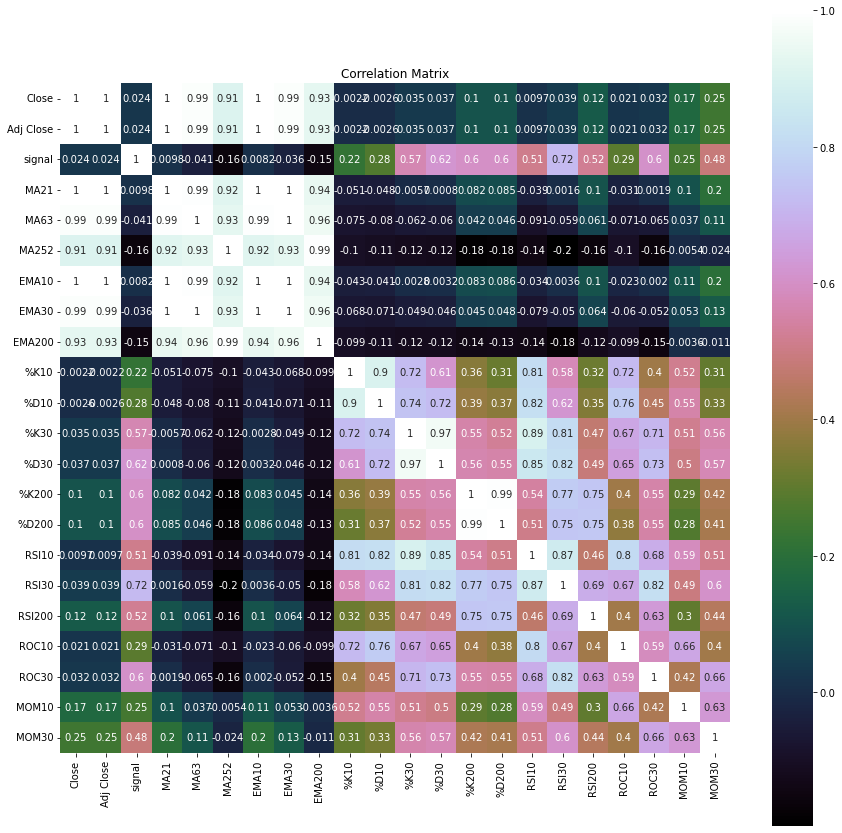

In [15]:
import seaborn as sns
# Correlation matrix
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Evaluate Models

In [16]:
# Train-Test split
from sklearn.model_selection import train_test_split
Y= dataset["signal"]
X = dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [17]:
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [19]:
from sklearn.model_selection import KFold, cross_val_score
# k-fold cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.909242 (0.026433)
LDA: 0.909267 (0.007250)
KNN: nan (nan)
CART: 0.913479 (0.015490)
NB: 0.820833 (0.018534)
NN: 0.832725 (0.037998)
AB: 0.926495 (0.011194)
GBM: 0.942182 (0.012074)
RF: 0.954446 (0.009734)


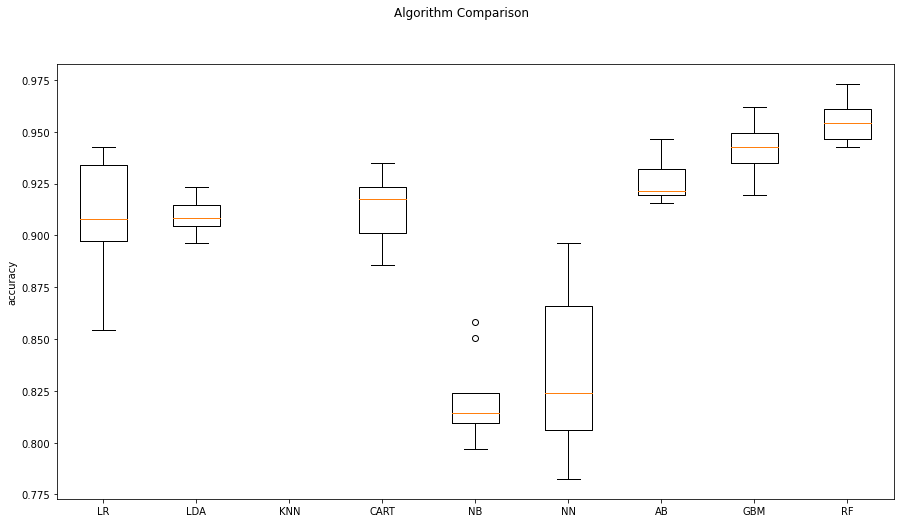

In [20]:
# compare algorithms metric
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel(scoring)
fig.set_size_inches(15,8)
plt.show()

Although some of the models show promising results, we prefer an ensemble model given the huge size of the dataset, the large number of features, and an expected non‐linear relationship between the predicted variable and the features. Random forest has the best performance among the ensemble models.

### Model tuning and grid search

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.952533 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.910415 (0.012367) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.916167 (0.014411) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.946404 (0.009038) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.952533 (0.010955) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.908896 (0.013790) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#8 0.908122 (0.011822) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.949463 (0.008706) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.949852 (0.009566) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


### Result on test dataset

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
model.fit(X_train, Y_train)

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9525267993874426
[[263  15]
 [ 16 359]]
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       278
         1.0       0.96      0.96      0.96       375

    accuracy                           0.95       653
   macro avg       0.95      0.95      0.95       653
weighted avg       0.95      0.95      0.95       653



<Axes: xlabel='Predicted', ylabel='Actual'>

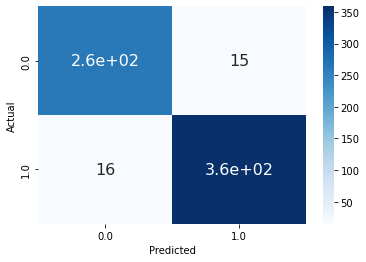

In [23]:
# Confusion matrix
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

#### Look at the feature importance
Feature importance chart corroborates the fact that introducing new features leads to an improvement in the model performance.

Text(0.5, 0, 'Variable Importance')

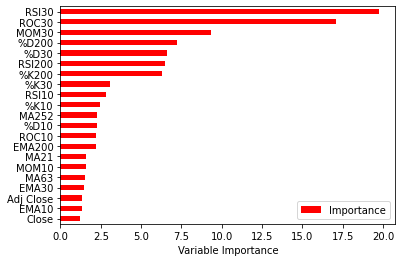

In [24]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

### Backtesting
We perform a backtest on the model we’ve developed. We create a column for strategy returns by multiplying the daily returns by the position that was held at the close of business the previous day and compare it against the actual returns.

<Axes: >

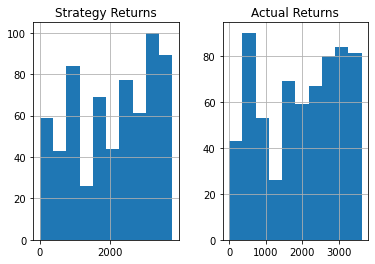

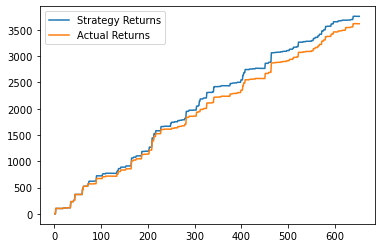

In [25]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()